# PSF Simulation with Gaussian Beamlet Decomposition
_written by Jaren Ashcraft_

Traditional diffraction simulation is typically done by projecting some signal $U$ onto an infinite sum of some elementary wave (plane, parabolic, spherical waves). Gaussian Beamlet Decomposition is a different take on this, where $U$ is instead projected onto a finite sum of Gaussian Beams.

Why Gaussian Beams? A great question. One reason is that they are "eigenfunctions of free space propagation". Put plainly, they don't change their shape when they move, they just get bigger or smaller. This fact means that there is a geometric mapping of a Gaussian beam through an optical system that essentially just squishes it.

Rays happen to be pretty good at determining this geometric mapping, and Gaussian beams are extremely localized. Therefore, we can consider a regime of optical propagation where rays instead look more like Gaussian beams. A collection of rays then, should be capable of representing a wavefront propagating through an optical system.

We recently built into Poke the ability to perform these simulations using a method we derived from the literature. The details of the method can be found in [1] but attention must be paid to the modern papers in this area that inspired this work [2,3]

In this tutorial we will focus on how to use Gaussian Beamlet Decomposition (GBD) in Poke to perform a simple PSF simulation

**References**
- [1] [Ashcraft et al, "Hybrid propagation physics for the design and modeling of astronomical observatories: a coronagraphic example", published in SPIE JATIS 2023](https://arxiv.org/abs/2310.20026)
- [2] [Harvey et al, "Modeling physical optics phenomena by complex ray tracing", published in SPIE Optical Engineering 2015](https://www.spiedigitallibrary.org/journals/optical-engineering/volume-54/issue-03/035105/Modeling-physical-optics-phenomena-by-complex-ray-tracing/10.1117/1.OE.54.3.035105.full#_=_)
- [3] [Worku and Gross, "Propagation of truncated Gaussian beams and their application in modeling sharp-edge diffraction", published in Optica JOSA A 2019](https://opg.optica.org/josaa/abstract.cfm?uri=josaa-36-5-859#:~:text=DEFINITION%20OF%20TRUNCATED%20GAUSSIAN%20BEAMS,-The%20electric%20field&text=We%20define%20a%20half%20Gaussian,through%20the%20Gaussian%20beam%20center.)

## Setting up the Rayfront
We begin as we do any problem in Poke, by setting up a Rayfront. We will be using the `Hubble_Test.zmx` file inclcuded in `poke/tests` for this experiment.

In [1]:
from poke.poke_core import Rayfront

pth = 'C:/Users/UASAL-OPTICS/Desktop/poke/tests/Hubble_Test.zmx'
nrays = 100
wvl = 1e-6
pupil_radius = 2.4/2
max_fov = 0.08

s1 = {
    'surf': 2,
    'mode': 'reflect'
}

s2 = {
    'surf': 11,
    'mode': 'reflect'
}

rf = Rayfront(nrays,wvl,pupil_radius,max_fov)


norm fov =  [0. 0.]


We next need to enable the Gaussian Beamlets simulation option by calling the `Rayfront.as_gaussianbeamlets()` method. The only argument to supply here is the size of the Gaussian beam to decompose an incoming wavefront into, which is called `wo` below.

In [2]:
wo = 0.024 # size of a gaussian beam
rf.as_gaussianbeamlets(wo)

Next, we trace the rays

In [3]:
import zosapi
zosapi.App()
rf.trace_rayset(pth,surfaces=[s1,s2])

5 Raysets traced through 2 surfaces


This loads the ray data into the Rayfront so that we can do the Gaussian Beamlet Decomposition calculation. Next we need to set up the coordinates at which we will be evaluating the field. For a simple imaging system, we consider a detector at the image plane. GBD simulations are done assuming a local coordinate system where the optical axis is at `[x,y,z] = [0,0,0]`. Below we show how to survey a grid of points centered around the optical axis. These points should be included as an array of points (`dcoords`) to the `Rayfront.beamlet_decomposition_field` method.

In [4]:
# set up field evaluation positions
import numpy as np
x = np.linspace(-5e-4, 5e-4, 256)
x, y = np.meshgrid(x, x)

dcoords = np.array([
    x.ravel(),
    y.ravel(),
    np.zeros_like(x.ravel())
])
field = rf.beamlet_decomposition_field(dcoords)

computeunit =  451
override nloops =  18
(3, 65536)
(3,)
centroid at =  [-7.51901559e-18 -7.79845605e-18  0.00000000e+00]
centroid offset applied


The output is a `field` in the shape of the supplied `dcoords`

In [5]:
print(dcoords.shape)
print(field.shape)

(3, 65536)
(65536,)


We can then plot the resulting field, which looks remarkably like an airy function. 

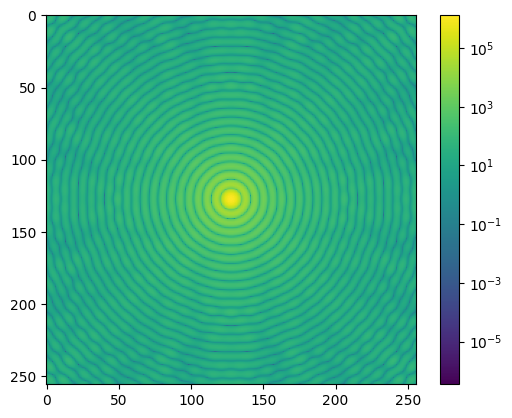

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

shaped_field = field.reshape([256,256])
plt.imshow(np.abs(shaped_field)**2,norm=LogNorm())
plt.colorbar()

This example is illustrative of a few things about GBD. First, we will notice the high-frequency ripples present particularly toward the edge of the PSF. This is due to GBD's inability to accurately reconstruct the edge of a circular aperture. One way we can mitigate this is to simply use a greater number of smaller beamlets, which we try below:

In [13]:
nrays = 200
wo = 0.006
rf_200 = Rayfront(nrays,wvl,pupil_radius,max_fov)
rf_200.as_gaussianbeamlets(wo)
rf_200.trace_rayset(pth, surfaces=[s1,s2])
field_200 = rf_200.beamlet_decomposition_field(dcoords)

norm fov =  [0. 0.]
5 Raysets traced through 2 surfaces
computeunit =  470
override nloops =  67
(3, 65536)
(3,)
centroid at =  [-9.82069588e-19 -1.00577626e-18  0.00000000e+00]
centroid offset applied


The computational effort required for this is much greater, but results in the following field that reconstructs the Airy disc much better

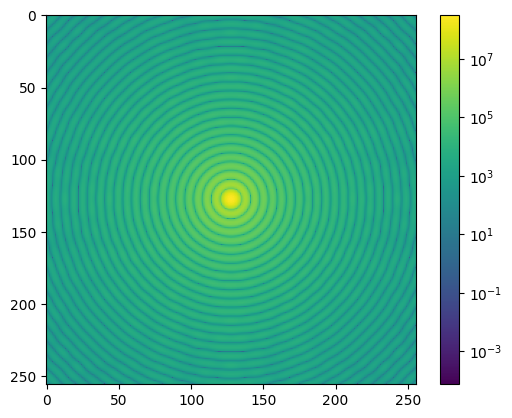

In [14]:
shaped_field_200 = field_200.reshape([256,256])
plt.imshow(np.abs(shaped_field_200)**2,norm=LogNorm())
plt.colorbar()

The GBD module is quite experimental, and we have so far only explored its use for imaging applications. However, GBD is generally used in other fields such as illumination engineering, and high-energy laser stray light analysis.